In [1]:
import matplotlib.pyplot as plt
import numpy as np

from beams import *

# Solidspy 1.1.0
import solidspy.preprocesor as pre
import solidspy.assemutil as ass    
import solidspy.solutil as sol      
import solidspy.postprocesor as pos 
import solidspy.uelutil as uel 

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def is_equilibrium(nodes, mats, els, loads):
    """
    Check if the system is in equilibrium
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    mats : ndarray
        Array with models materials
    els : ndarray
        Array with models elements
    loads : ndarray
        Array with models loads
        
    Returns
    -------
    equil : bool
        Variable True when the system is in equilibrium and False when it doesn't
    """   

    equil = True
    assem_op, bc_array, neq = ass.DME(nodes[:, -2:], els)
    stiff_mat, _ = ass.assembler(els, mats, nodes[:, :3], neq, assem_op)
    rhs_vec = ass.loadasem(loads, bc_array, neq)
    disp = sol.static_sol(stiff_mat, rhs_vec)
    if not np.allclose(stiff_mat.dot(disp)/stiff_mat.max(), rhs_vec/stiff_mat.max()):
        equil = False

    return equil
    
def preprocessing(nodes, mats, els, loads):
    """
    Compute IBC matrix and the static solve.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    mats : ndarray
        Array with models materials
    els : ndarray
        Array with models elements
    loads : ndarray
        Array with models loads
        
    Returns
    -------
    bc_array : ndarray 
        Boundary conditions array
    disp : ndarray 
        Static displacement solve.
    """   

    assem_op, bc_array, neq = ass.DME(nodes[:, -2:], els, ndof_el_max=8)

    # System assembly
    stiff_mat, _ = ass.assembler(els, mats, nodes[:, :3], neq, assem_op)
    rhs_vec = ass.loadasem(loads, bc_array, neq)

    # System solution
    disp = sol.static_sol(stiff_mat, rhs_vec)
    if not np.allclose(stiff_mat.dot(disp)/stiff_mat.max(),
                       rhs_vec/stiff_mat.max()):
        print("The system is not in equilibrium!")
    return bc_array, disp


def postprocessing(nodes, mats, els, bc_array, disp):
    """
    Compute the nodes displacements, strains and stresses.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    mats : ndarray
        Array with models materials
    els : ndarray
        Array with models elements
    IBC : ndarray 
        Boundary conditions array
    UG : ndarray 
        Static solve.
        
    Returns
    -------
    disp_complete : ndarray 
        Displacements at elements.
    strain_nodes : ndarray 
        Strains at elements.
    stress_nodes : ndarray 
        Stresses at elements.
    """   
    
    disp_complete = pos.complete_disp(bc_array, nodes, disp)
    strain_nodes, stress_nodes = None, None
    strain_nodes, stress_nodes = pos.strain_nodes(nodes, els, mats, disp_complete)
    
    return disp_complete, strain_nodes, stress_nodes

In [3]:
def protect_els(els, loads, BC):
    """
    Compute an mask array with the elements that don't must be deleted.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    els : ndarray
        Array with models elements
    loads : ndarray
        Array with models loads
    BC : ndarray 
        Boundary conditions nodes
        
    Returns
    -------
    mask_els : ndarray 
        Array with the elements that don't must be deleted.
    """   
    mask_els = np.ones_like(els[:,0], dtype=bool)
    protect_nodes = np.hstack((loads[:,0], BC)).astype(int)
    protect_index = None
    for p in protect_nodes:
        protect_index = np.argwhere(els[:, -4:] == p)[:,0]
        mask_els[protect_index] = False
        
    return mask_els
    
def del_node(nodes, els):
    """
    Retricts nodes dof that aren't been used.
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    els : ndarray
        Array with models elements

    Returns
    -------
    """   
    n_nodes = nodes.shape[0]
    for n in range(n_nodes):
        if n not in els[:, -4:]:
            nodes[n, -2:] = -1

def sensi_el(nodes, mats, els, UC):
    """
    Calculate the sensitivity number for each element.
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    mats : ndarray
        Array with models materials
    els : ndarray
        Array with models elements
    UC : ndarray
        Displacements at nodes

    Returns
    -------
    sensi_number : ndarray
        Sensitivity number for each element.
    """   
    sensi_number = []
    for el in range(len(els)):
        params = tuple(mats[els[el, 2], :])
        elcoor = nodes[els[el, -4:], 1:3]
        kloc, _ = uel.elast_quad4(elcoor, params)

        node_el = els[el, -4:]
        U_el = UC[node_el]
        U_el = np.reshape(U_el, (8,1))
        a_i = U_el.T.dot(kloc.dot(U_el))[0,0]
        sensi_number.append(a_i)
    sensi_number = np.array(sensi_number)

    return sensi_number

In [4]:
nodes, mats, els, loads, BC = beam_1(L=10, H=24, nx=20, ny=40)
elsI,nodesI = np.copy(els), np.copy(nodes)

In [5]:
IBC, UG = preprocessing(nodes, mats, els, loads)
UCI, E_nodesI, S_nodesI = postprocessing(nodes, mats, els, IBC, UG)

In [6]:
niter = 50
RR = 0.01
ER = 0.005
V_opt = int(len(els) * 0.50)
ELS = None
for _ in range(niter):
    if not is_equilibrium(nodes, mats, els, loads) or len(els) < V_opt: 
        print('Is not equilibrium')
        break
    
    IBC, UG = preprocessing(nodes, mats, els, loads)
    UC, E_nodes, S_nodes = postprocessing(nodes, mats, els, IBC, UG)

    sensi_number = sensi_el(nodes, mats, els, UC)
    sensi_number = sensi_number/sensi_number.max()
    mask_del = sensi_number < RR
    mask_els = protect_els(els, loads, BC)
    mask_del *= mask_els
    ELS = els
    
    els = np.delete(els, mask_del, 0)
    del_node(nodes, els)
    RR += ER
print(RR)

Is not equilibrium
0.22500000000000012


c:\users\santy\onedrive - universidad eafit\documents\universidad\babyoptalgorithm\solidspy\solidspy\postprocesor.py:107: UserWarning: The following kwargs were not used by contour: 'shading'
  disp_plot(tri, field, levels, shading="gouraud")


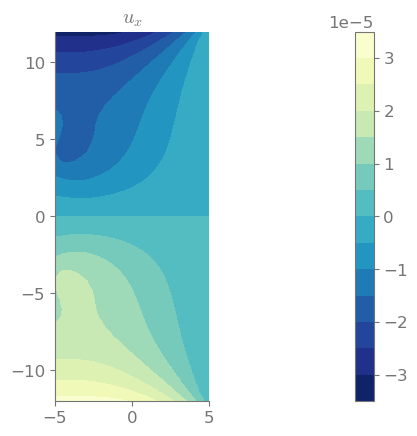

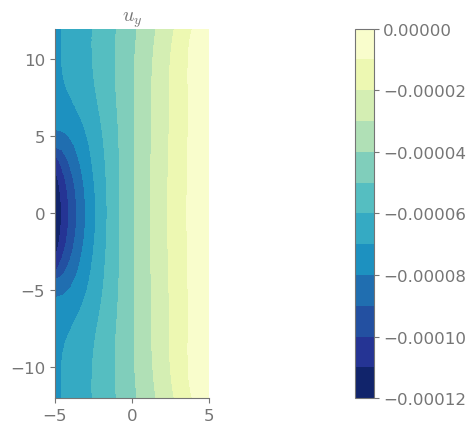

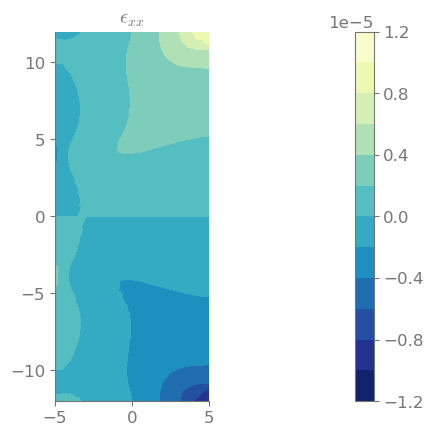

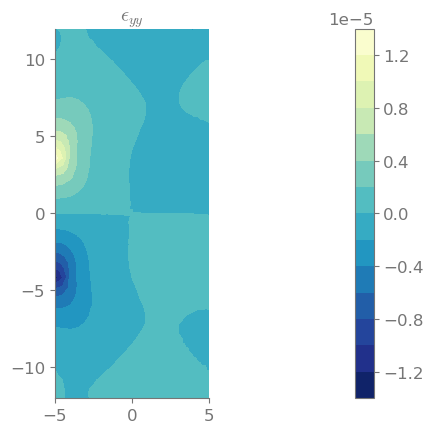

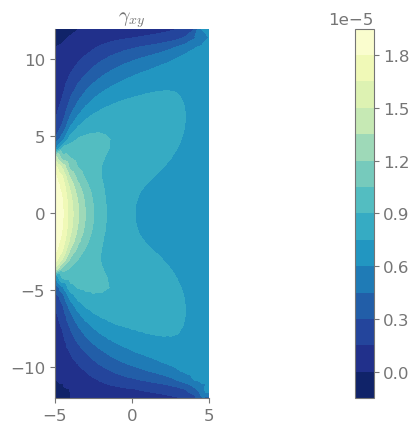

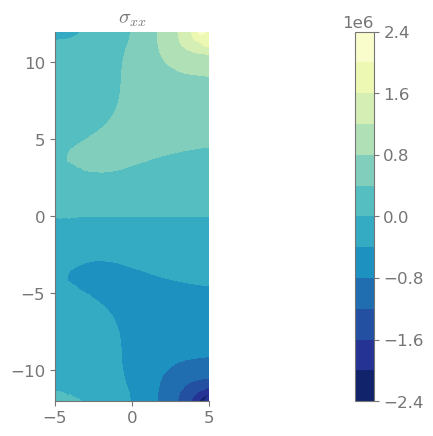

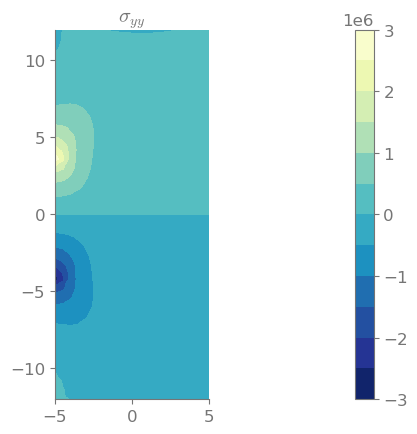

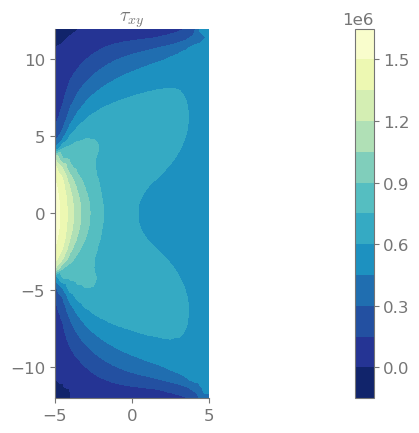

In [7]:
pos.fields_plot(elsI, nodes, UCI, E_nodes=E_nodesI, S_nodes=S_nodesI)

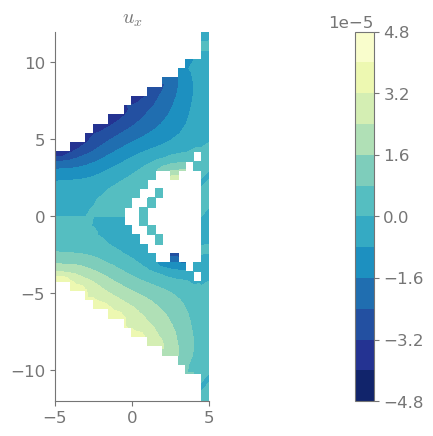

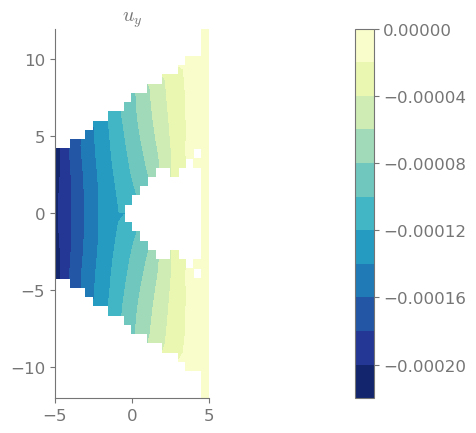

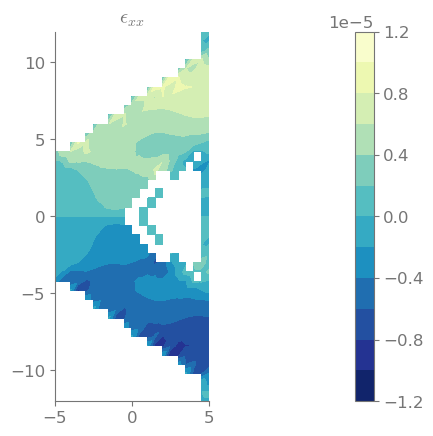

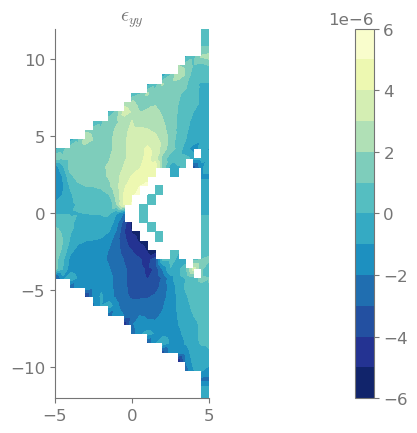

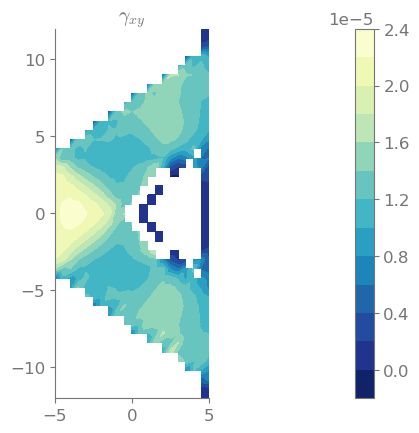

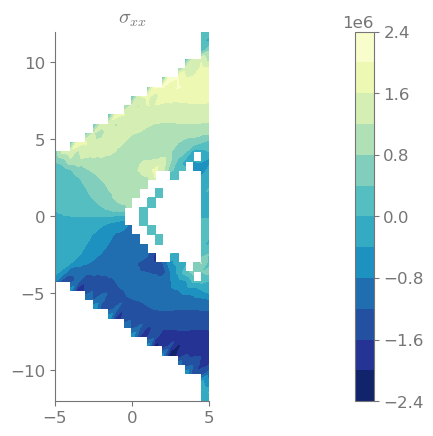

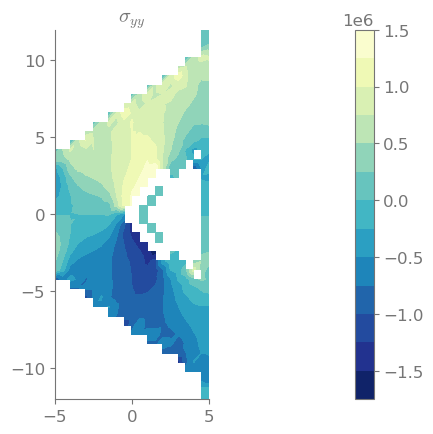

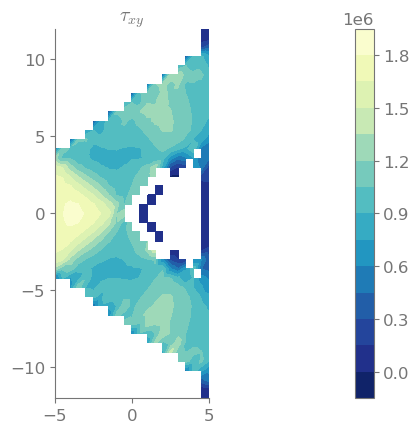

In [8]:
pos.fields_plot(ELS, nodes, UC, E_nodes=E_nodes, S_nodes=S_nodes)